In [13]:
import os
import polars as pl
from dataclasses import dataclass

PROJECT_PATH = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding"

@dataclass
class SampleConfig:
    label: str
    sample: str
    ground_truth_file: str

# create a list of SampleConfig objects
sample_configs = [
    SampleConfig(label="FOX-Contrasting", sample="Hep_G2", ground_truth_file=f"{PROJECT_PATH}/data/data_splits/validation_FOXA1_FOXA2.csv"),
]


In [ ]:

def enrich_chip_data(chip_df, reference_df):
    """
    Add probabilities and predicted columns from reference dataframe to chip dataframe
    by matching on chr, start, and end coordinates.
    
    Args:
        chip_df: The chip data dataframe to enrich
        reference_df: The source dataframe containing probabilities and predicted values
        
    Returns:
        Enriched chip dataframe with added columns
    """
    # Join chip_data with df on the chromosome coordinates
    enriched_chip_df = chip_df.join(
        reference_df.select(['chr', 'start', 'end', 'probabilities', 'predicted']),
        on=['chr', 'start', 'end'],
        how='left'
    )
    
    return enriched_chip_df


dfs = []
for sample_config in sample_configs:
    parquet_path = PROJECT_PATH + "/data/processed_results/" + sample_config.label + "_" + sample_config.sample + "_processed.parquet"
    df = pl.read_parquet(parquet_path, columns=["chr_name", "start", "end", "cell_line", "targets", "predicted", "weights", "probabilities"])
    df = df.rename({"chr_name": "chr"})
    chip_data = pl.read_csv(sample_config.ground_truth_file, separator="\t", has_header=False, new_columns=["chr", "start", "end", "count"])
    # Apply the function to add the columns
    enriched_chip_data = enrich_chip_data(chip_data, df)

dfs[0]

chr,start,end,cell_line,targets,predicted,weights,probabilities
str,i64,i64,str,i32,f64,f64,f64
"""chr18""",30513007,30513835,"""Hep_G2""",0,0.0,-1.0,0.003926
"""chr1""",211734449,211736931,"""Hep_G2""",0,0.0,-1.0,0.007116
"""chr1""",214898461,214898965,"""Hep_G2""",0,0.0,-1.0,0.003746
"""chr13""",90756972,90757360,"""Hep_G2""",0,0.0,-1.0,0.004194
"""chr3""",178475002,178475708,"""Hep_G2""",0,0.0,-1.0,0.003004
…,…,…,…,…,…,…,…
"""chr2""",178296724,178297395,"""Hep_G2""",0,0.0,-1.0,0.005515
"""chr19""",56927315,56928144,"""Hep_G2""",0,0.0,-1.0,0.007596
"""chr8""",71706486,71706917,"""Hep_G2""",0,0.0,-1.0,0.005115



Performance Metrics:
----------------------------------------------------------------------------------------------------
Dataset                   Threshold  F1 Score   ROC AUC    PR AUC    
----------------------------------------------------------------------------------------------------
FOX-Contrasting (Hep_G2)  0.008     0.264     0.638     0.169


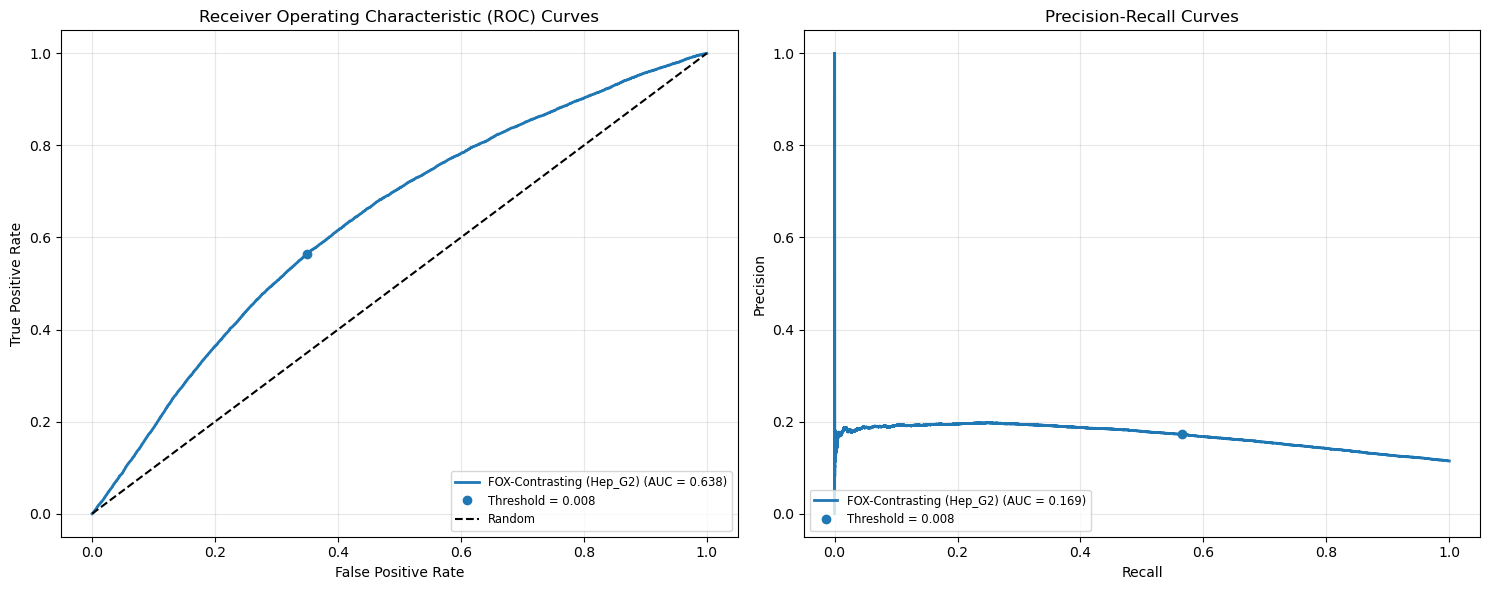


Confusion Matrix Metrics:
--------------------------------------------------------------------------------------------------------------------------------------------
Dataset                   Threshold  True Negative   False Positive  False Negative  True Positive   Total      Accuracy  
--------------------------------------------------------------------------------------------------------------------------------------------
FOX-Contrasting (Hep_G2)      0.008           83874           45039            7240            9392     145545     0.641
--------------------------------------------------------------------------------------------------------------------------------------------


In [9]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score, confusion_matrix
import matplotlib.pyplot as plt

def ensure_numpy(arr):
    """Convert input to numpy array if it isn't already."""
    return np.array(arr) if not isinstance(arr, np.ndarray) else arr

def find_best_f1_threshold(y_true, y_score):
    """Find the optimal threshold that gives the best F1 score."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 1.0
    return best_threshold, f1_scores[best_idx]

def get_display_name(config):
    """Get display name based on sample and label if available."""
    return f"{config.label} ({config.sample})" if hasattr(config, 'label') and config.label else config.sample

def print_confusion_metrics(dfs, sample_configs, threshold=None):
    """
    Print confusion matrix metrics for multiple datasets.
    
    Args:
        dfs: List of dataframes containing targets and probabilities
        sample_configs: List of sample configurations for labeling
        threshold: Optional fixed threshold to use. If None, finds best F1 threshold
    """
    print("\nConfusion Matrix Metrics:")
    print("-" * 140)
    headers = ["Dataset", "Threshold", "True Negative", "False Positive", "False Negative", "True Positive", "Total", "Accuracy"]
    print(f"{headers[0]:<25} {headers[1]:<10} {headers[2]:<15} {headers[3]:<15} {headers[4]:<15} {headers[5]:<15} {headers[6]:<10} {headers[7]:<10}")
    print("-" * 140)
    
    for df, config in zip(dfs, sample_configs):
        y_true = ensure_numpy(df["targets"])
        y_score = ensure_numpy(df["probabilities"])
        
        # Determine threshold
        if threshold is None:
            best_threshold, _ = find_best_f1_threshold(y_true, y_score)
            used_threshold = best_threshold
        else:
            used_threshold = threshold
        
        # Get predictions using threshold
        y_pred = (y_score >= used_threshold).astype(int)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        total = tn + fp + fn + tp
        accuracy = (tp + tn) / total
        
        display_name = get_display_name(config)
        print(f"{display_name:<25} {used_threshold:>9.3f} {tn:>15} {fp:>15} {fn:>15} {tp:>15} {total:>10} {accuracy:>9.3f}")
    
    print("-" * 140)

def plot_performance_curves(dfs, sample_configs, threshold=None):
    """
    Plot ROC and PR curves for multiple datasets side by side.
    
    Args:
        dfs: List of dataframes containing targets and probabilities
        sample_configs: List of sample configurations for labeling
        threshold: Optional fixed threshold to use. If None, finds best F1 threshold
    """
    fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(15, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(dfs)))
    
    print("\nPerformance Metrics:")
    print("-" * 100)
    print(f"{'Dataset':<25} {'Threshold':<10} {'F1 Score':<10} {'ROC AUC':<10} {'PR AUC':<10}")
    print("-" * 100)
    
    for idx, (df, config, color) in enumerate(zip(dfs, sample_configs, colors)):
        y_true = ensure_numpy(df["targets"])
        y_score = ensure_numpy(df["probabilities"])
        display_name = get_display_name(config)
        
        # Determine threshold
        if threshold is None:
            best_threshold, _ = find_best_f1_threshold(y_true, y_score)
            used_threshold = best_threshold
        else:
            used_threshold = threshold
        
        # Get predictions for F1 score
        y_pred = (y_score >= used_threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        
        # ROC curve
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        ax_roc.plot(fpr, tpr, color=color, lw=2,
                   label=f'{display_name} (AUC = {roc_auc:.3f})')
                   
        # Find and plot threshold point on ROC
        thresh_idx = np.argmin(np.abs(roc_thresholds - used_threshold))
        ax_roc.plot(fpr[thresh_idx], tpr[thresh_idx], 'o', color=color,
                   label=f'Threshold = {used_threshold:.3f}')
        
        # PR curve
        precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
        pr_auc = auc(recall, precision)
        
        # Plot PR curve
        ax_pr.plot(recall, precision, color=color, lw=2,
                  label=f'{display_name} (AUC = {pr_auc:.3f})')
                  
        # Find and plot threshold point on PR
        if len(pr_thresholds) > 0:  # Handle edge case
            thresh_idx = np.argmin(np.abs(pr_thresholds - used_threshold))
            if thresh_idx < len(recall):  # Ensure index is valid
                ax_pr.plot(recall[thresh_idx], precision[thresh_idx], 'o', 
                         color=color,
                         label=f'Threshold = {used_threshold:.3f}')
        
        # Print metrics
        print(f"{display_name:<25} {used_threshold:.3f}     {f1:.3f}     "
              f"{roc_auc:.3f}     {pr_auc:.3f}")
    
    # ROC plot settings
    ax_roc.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random')
    ax_roc.set_xlim([-0.05, 1.05])
    ax_roc.set_ylim([-0.05, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('Receiver Operating Characteristic (ROC) Curves')
    ax_roc.legend(loc='lower right', fontsize='small')
    ax_roc.grid(True, alpha=0.3)
    
    # PR plot settings
    ax_pr.set_xlim([-0.05, 1.05])
    ax_pr.set_ylim([-0.05, 1.05])
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title('Precision-Recall Curves')
    ax_pr.legend(loc='lower left', fontsize='small')
    ax_pr.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Use with fixed threshold can also do None for best F1 threshold
threshold = None
plot_performance_curves(dfs, sample_configs, threshold=threshold)
print_confusion_metrics(dfs, sample_configs, threshold=threshold)